In [1]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from src.time_series_functions import *
# from pandas.plotting import register_matplotlib_converters
# register_matplotlib_converters()

# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
keras = tf.keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
# from keras.callbacks import EarlyStopping#, ModelCheckpoint
from keras.metrics import MeanAbsolutePercentageError


%matplotlib inline

Using TensorFlow backend.


In [2]:
#load in master df
base_df = csv_with_datetime('data/master_df.csv', 'ds')
df = base_df.copy()
df.drop('Unnamed: 0', axis=1, inplace=True)
df.info(), df.head(3)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11323 entries, 1990-01-01 to 2020-12-31
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   ds            11323 non-null  datetime64[ns]
 1   y             11323 non-null  float64       
 2   avg_temp      11323 non-null  float64       
 3   precip_accum  11323 non-null  float64       
 4   swe           11323 non-null  float64       
 5   hist_avg_y    11323 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 619.2 KB


(None,
                    ds    y  avg_temp  precip_accum  swe  hist_avg_y
 ds                                                                 
 1990-01-01 1990-01-01  6.5      19.0           5.6  4.8    6.437742
 1990-01-02 1990-01-02  6.9      16.0           5.7  4.8    6.502258
 1990-01-03 1990-01-03  6.9       2.0           5.7  4.8    6.673226)

In [3]:
int('2020')

2020

In [26]:
#functionize to take a year and produce graph, rmse, and lift over historical avg model. 
#function requires a minimum of 6000 samples, set pred_year accordingly
#function designed to work with project-specific column names, edits would be required to work with other data

def year_eval_lstm(model, pred_year, master_df):
    df = master_df.copy()
    
    #making desired year last year in sample data
    samp_df = df[:pred_year]

    #trimming sample data to 6000 records total
    samp_df = samp_df.iloc[-6000:]

    # convert datetime column to continuous integer
    samp_df['ds'] = pd.to_datetime(df['ds']).sub(pd.Timestamp(df['ds'].iloc[0])).dt.days
    
    #don't pass in historical y to model
    samp_df.drop('hist_avg_y', axis=1, inplace=True)
    
    # scale entire dataframe except y column 
    scale_df = samp_df.copy()
    for column in scale_df.columns:
      if column != 'y':
        scaler = StandardScaler()
        # print (scale_df[column].values.shape)
        holder = scaler.fit_transform(scale_df[column].values.reshape(-1,1))
        scale_df[column] = holder.reshape(len(scale_df),)
        
    #test size depends if year is leap year or not
    test_size = 365
    if int(pred_year)%4 == 0:
        test_size = 366
        
    #these variables can't be changed without retraining models used in this project
    n_prev = 400 #model was trained on this input shape
    predict_steps = 30 #model was trained on this output shape
    
    #utilizes windowize_data function
    X, y = windowize_data(scale_df, n_prev, 'y', predict_steps)
    X_test = X[-test_size:]
    y_test = y[-test_size:]
    
    #use model to make predictions and make 0 the lower limit of predictions
    y_pred = model.predict(X_test)
    y_pred[y_pred<0] = 0

    
    #grab predictions at 1-day, 14-days, and 30-days out for each day of the year
    day_1_pred = y_pred[:,:1]          
    day_14_pred = y_pred[:,13:14]
    day_30_pred = y_pred[:,-1:]
    
    #collect and print rmse for 1-day, 14-days, and 30-days prediction sets
    day_1_rmse  = sqrt(mean_squared_error(y_test[:,:1], day_1_pred))
    day_14_rmse = sqrt(mean_squared_error(y_test[:,13:14], day_14_pred))
    day_30_rmse = sqrt(mean_squared_error(y_test[:,-1:], day_30_pred))
    print(f'For prediction year {pred_year}:')
    print(f'1-Day RMSE = {day_1_rmse}')
    print(f'14-Day RMSE = {day_14_rmse}')
    print(f'30-Day RMSE = {day_30_rmse}')
    
    #collect historical average set, calculate rmse over actuals, and compare lift over historical average
    hist_avg_set = df[pred_year]['hist_avg_y']
    hist_avg_rmse = sqrt(mean_squared_error(y_test[:,:1], hist_avg_set))
    
    day_1_lift = 1-(day_1_rmse/hist_avg_rmse)
    day_14_lift = 1-(day_14_rmse/hist_avg_rmse)
    day_30_lift = 1-(day_30_rmse/hist_avg_rmse)
    
    #print lifts over historical average
    print(f'Historical average vs. actuals RMSE: {hist_avg_rmse}')
    print('\n')
    print('Model lift over historical average method')
    print(f'1-Day: {day_1_lift*100}%')
    print(f'14-Day: {day_14_lift*100}%')
    print(f'30-Day: {day_30_lift*100}%')
    
    return day_1_rmse, day_14_rmse, day_30_rmse, hist_avg_rmse, day_1_lift, day_14_lift, day_30_lift
    

        

In [187]:
lstm_v12 = keras.models.load_model('models/LSTM_v12.h5')
lstm_v9 = keras.models.load_model('models/LSTM_v9.h5')
lstm_v7 = keras.models.load_model('models/LSTM_v7.h5')
lstm_v10 = keras.models.load_model('models/LSTM_v10.h5')

In [227]:
###testing all models at various performance intervals across 5 years. v10 clear winner. 

# from statistics import mean
# year_list = ['2016', '2017', '2018', '2019', '2020']
# model_list = [lstm_v7, lstm_v9, lstm_v10, lstm_v12]
# name_list = ['v7', 'v9', 'v10', 'v12']

# for mod, mod_name in zip(model_list, name_list):
#     day_rmse_list = []
#     weeks_rmse_list = []
#     month_rmse_list = []
#     for year in year_list:
#         eval_result = year_eval_lstm(mod, year, df)
#         day_rmse_list.append(eval_result[0])
#         weeks_rmse_list.append(eval_result[1])
#         month_rmse_list.append(eval_result[2])
#     avg_day_rmse = mean(day_rmse_list)
#     avg_weeks_rmse = mean(weeks_rmse_list)
#     avg_month_rmse = mean(month_rmse_list)
#     print (f'{mod_name} RMSE stats: ')
#     print (f'avg_day_rmse = {avg_day_rmse}')
#     print (f'avg_weeks_rmse = {avg_weeks_rmse}')
#     print (f'avg_month_rmse = {avg_month_rmse}')
    

In [243]:
year_eval_lstm(lstm_v10, '2020', df)

For prediction year 2020:
1-Day RMSE = 10.977083307545541
14-Day RMSE = 14.472413753804501
30-Day RMSE = 19.726206039264994
Historical average vs. actuals RMSE: 23.860292964449997


Model lift over historical average method
1-Day: 53.99434816705497%
14-Day: 39.3451967443682%
30-Day: 17.32622030812645%


(10.977083307545541,
 14.472413753804501,
 19.726206039264994,
 23.860292964449997,
 0.5399434816705497,
 0.39345196744368205,
 0.1732622030812645)

In [230]:
#functionize to take a year and produce graph showing actual, hist_avg, 1-day, 14-day, 30-day predictions. 
#function requires a minimum of 6000 samples, set pred_year accordingly
#function designed to work with project-specific column names, edits would be required to work with other data

def year_graph_lstm(model, model_name_string, pred_year, master_df):
    df = master_df.copy()
    
    #making desired year last year in sample data
    samp_df = df[:pred_year].copy()

    #trimming sample data to 6000 records total
    samp_df = samp_df.iloc[-6000:]

    # convert datetime column to continuous integer
    samp_df['ds'] = pd.to_datetime(df['ds']).sub(pd.Timestamp(df['ds'].iloc[0])).dt.days
    
    #don't pass in historical y to model
    samp_df.drop('hist_avg_y', axis=1, inplace=True)
    
    # scale entire dataframe except y column 
    scale_df = samp_df.copy()
    for column in scale_df.columns:
      if column != 'y':
        scaler = StandardScaler()
        # print (scale_df[column].values.shape)
        holder = scaler.fit_transform(scale_df[column].values.reshape(-1,1))
        scale_df[column] = holder.reshape(len(scale_df),)
        
    #test size depends if year is leap year or not
    test_size = 365
    if int(pred_year)%4 == 0:
        test_size = 366
        
    #these variables can't be changed without retraining models used in this project
    n_prev = 400 #model was trained on this input shape
    predict_steps = 30 #model was trained on this output shape
    
    #utilizes windowize_data function
    X, y = windowize_data(scale_df, n_prev, 'y', predict_steps)
    X_test = X[-test_size:]
    y_test = y[-test_size:]
    
    #use model to make predictions and make 0 the lower limit of predictions
    y_pred = model.predict(X_test)
    y_pred[y_pred<0] = 0
#     print(y_pred)

    
    #grab predictions at 1-day, 14-days, and 30-days out for each day of the year
    day_1_pred = y_pred[:,:1]
    day_14_pred = y_pred[:,13:14]
    day_30_pred = y_pred[:,-1:]
#     print(df[pred_year].index[30:])
  
#     plot actual, hist_avg, and 1-day, 14-day, and 30-day predictions
    plt.figure(figsize=(30,10))
    plt.plot(df[pred_year].index, df[pred_year]['y'],label='actual', linewidth=5);
    plt.plot(df[pred_year].index, df[pred_year]['hist_avg_y'],label='historical average', linewidth=3, color='green', alpha=0.8, linestyle='dashed')
    plt.plot(df[pred_year].index[:-30], day_1_pred[30:], label='1-day forecast', linewidth=3, color='purple', alpha=0.3)
    plt.plot(df[pred_year].index[:-14], day_14_pred[14:], label='14-day forecast', linewidth=5, color='red')
    plt.plot(df[pred_year].index, day_30_pred, label='30-day forecast', linewidth=5, color='orange', alpha=0.4)
    #formatting
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylabel('Streamflow CFS', fontsize=30)
    plt.legend(prop={"size":30})
    plt.savefig(f'graphs/{model_name_string}_yearly_{pred_year}.jpg')
    plt.show()
    
    pass
#########^^^^^^DO NOT DELETE^^^^^^#########


# ########DOESN'T THIS MAKE MORE SENSE FOR DATE RANGE OFFSETS??########
# #     plot actual, hist_avg, and 1-day, 14-day, and 30-day predictions
#     plt.figure(figsize=(30,10))
#     plt.plot(df[pred_year].index, df[pred_year]['y'],label='actual', linewidth=5);
#     plt.plot(df[pred_year].index, df[pred_year]['hist_avg_y'],label='historical average', linewidth=3, color='green', alpha=0.8, linestyle='dashed')
#     plt.plot(df[pred_year].index[1:], day_1_pred[:-1], label='1-day forecast', linewidth=3, color='purple', alpha=0.3)
#     plt.plot(df[pred_year].index[13:], day_14_pred[:-13], label='14-day forecast', linewidth=5, color='red')
#     plt.plot(df[pred_year].index[30:], day_30_pred[:-30], label='30-day forecast', linewidth=5, color='orange', alpha=0.4)
#     #formatting
#     plt.xticks(fontsize=20)
#     plt.yticks(fontsize=20)
#     plt.ylabel('Streamflow CFS', fontsize=30)
#     plt.legend(prop={"size":30})
# #     plt.savefig(f'graphs/{model_name_string}_yearly_{pred_year}.jpg')
#     plt.show()
# ##########^^^^^^DO NOT DELETE^^^^^^#########


    pass

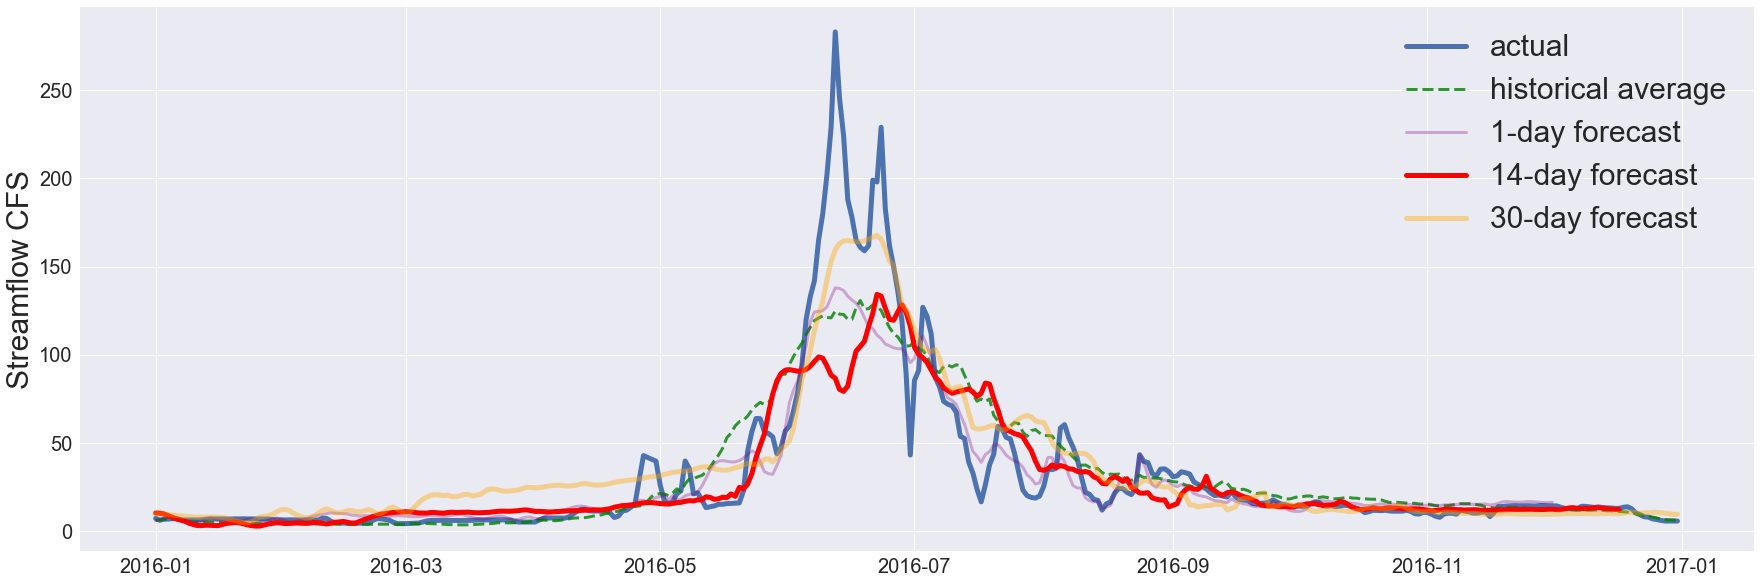

In [235]:
year_graph_lstm(lstm_v10, 'lstm_v10', '2016', df)

In [199]:
#functionize to take a year and produce graph showing actual, hist_avg, 1-day, 14-day, 30-day predictions. 
#function requires a minimum of 6000 samples, set pred_year accordingly
#function designed to work with project-specific column names, edits would be required to work with other data

def test_graph_lstm(model, model_name_string, pred_year, master_df):
    df = master_df.copy()
    
    #making desired year last year in sample data
    samp_df = df[:pred_year].copy()

    #trimming sample data to 6000 records total
    samp_df = samp_df.iloc[-6000:]

    # convert datetime column to continuous integer
    samp_df['ds'] = pd.to_datetime(df['ds']).sub(pd.Timestamp(df['ds'].iloc[0])).dt.days
    
    #don't pass in historical y to model
    samp_df.drop('hist_avg_y', axis=1, inplace=True)
    
    # scale entire dataframe except y column 
    scale_df = samp_df.copy()
    for column in scale_df.columns:
      if column != 'y':
        scaler = StandardScaler()
        # print (scale_df[column].values.shape)
        holder = scaler.fit_transform(scale_df[column].values.reshape(-1,1))
        scale_df[column] = holder.reshape(len(scale_df),)
        
    #test size depends if year is leap year or not
    test_size = 365
    if int(pred_year)%4 == 0:
        test_size = 366
        
    #these variables can't be changed without retraining models used in this project
    n_prev = 400 #model was trained on this input shape
    predict_steps = 30 #model was trained on this output shape
    
    #utilizes windowize_data function
    X, y = windowize_data(scale_df, n_prev, 'y', predict_steps)
    X_test = X[-test_size:]
    y_test = y[-test_size:]
    
    #use model to make predictions and make 0 the lower limit of predictions
    y_pred = model.predict(X_test)
    y_pred[y_pred<0] = 0
#     print(y_pred)

    
    #grab predictions at 1-day, 14-days, and 30-days out for each day of the year
    day_1_pred = y_pred[:,:1]
    day_14_pred = y_pred[:,13:14]
    day_30_pred = y_pred[:,-1:]
#     print(df[pred_year].index[30:])
  
# #######DO NOT DELETE########
# #     plot actual, hist_avg, and 1-day, 14-day, and 30-day predictions
#     plt.figure(figsize=(30,10))
#     plt.plot(df[pred_year].index, df[pred_year]['y'],label='actual', linewidth=5);
#     plt.plot(df[pred_year].index, df[pred_year]['hist_avg_y'],label='historical average', linewidth=3, color='green', alpha=0.8, linestyle='dashed')
#     plt.plot(df[pred_year].index[:-30], day_1_pred[30:], label='1-day forecast', linewidth=3, color='purple', alpha=0.3)
#     plt.plot(df[pred_year].index[:-14], day_14_pred[14:], label='14-day forecast', linewidth=5, color='red')
#     plt.plot(df[pred_year].index, day_30_pred, label='30-day forecast', linewidth=5, color='orange', alpha=0.4)
#     #formatting
#     plt.xticks(fontsize=20)
#     plt.yticks(fontsize=20)
#     plt.ylabel('Streamflow CFS', fontsize=30)
#     plt.legend(prop={"size":30})
# #     plt.savefig(f'graphs/{model_name_string}_yearly_{pred_year}.jpg')
#     plt.show()
# #########^^^^^^DO NOT DELETE^^^^^^#########


########DOESN'T THIS MAKE MORE SENSE FOR DATE RANGE OFFSETS??########
#     plot actual, hist_avg, and 1-day, 14-day, and 30-day predictions
    plt.figure(figsize=(30,10))
    plt.plot(df[pred_year].index, df[pred_year]['y'],label='actual', linewidth=5);
    plt.plot(df[pred_year].index, df[pred_year]['hist_avg_y'],label='historical average', linewidth=3, color='green', alpha=0.8, linestyle='dashed')
    plt.plot(df[pred_year].index[1:], day_1_pred[:-1], label='1-day forecast', linewidth=3, color='purple', alpha=0.3)
    plt.plot(df[pred_year].index[13:], day_14_pred[:-13], label='14-day forecast', linewidth=5, color='red')
    plt.plot(df[pred_year].index[30:], day_30_pred[:-30], label='30-day forecast', linewidth=5, color='orange', alpha=0.4)
    #formatting
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylabel('Streamflow CFS', fontsize=30)
    plt.legend(prop={"size":30})
#     plt.savefig(f'graphs/{model_name_string}_yearly_{pred_year}.jpg')
    plt.show()
##########^^^^^^DO NOT DELETE^^^^^^#########


    pass

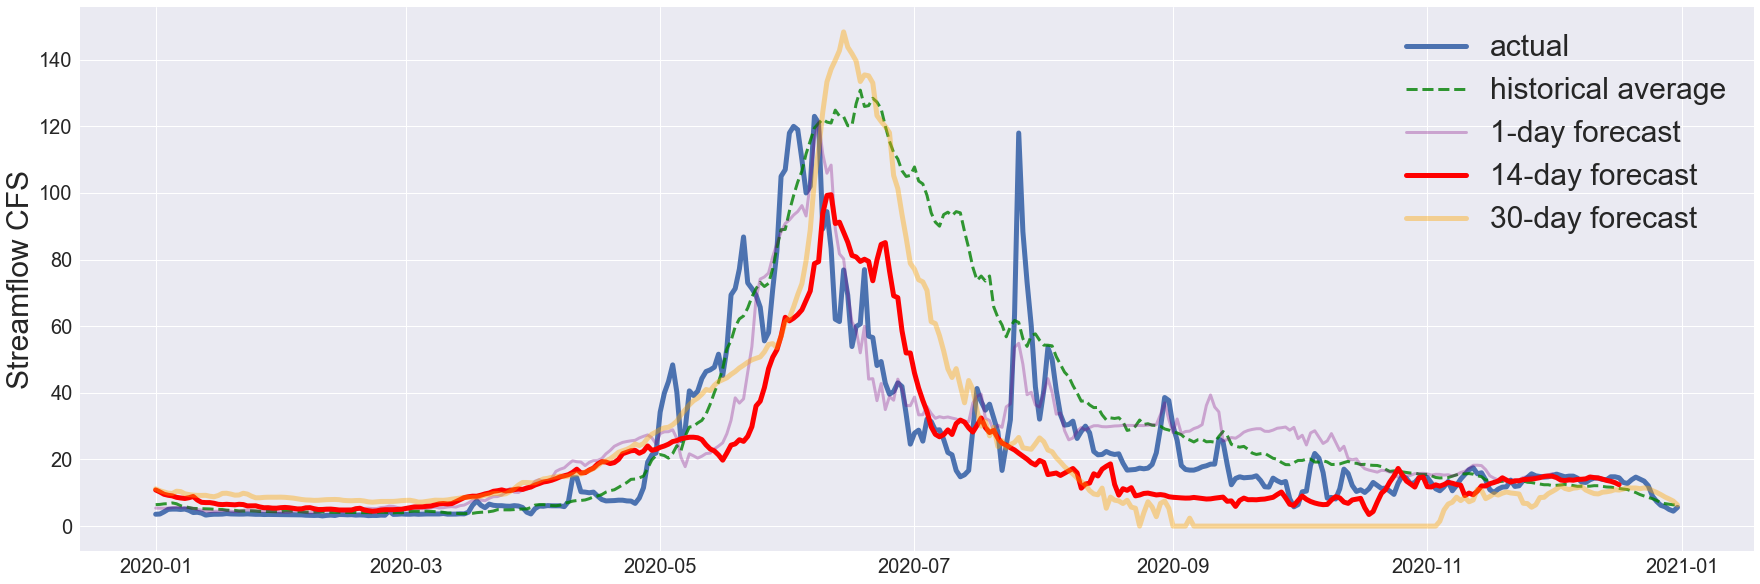

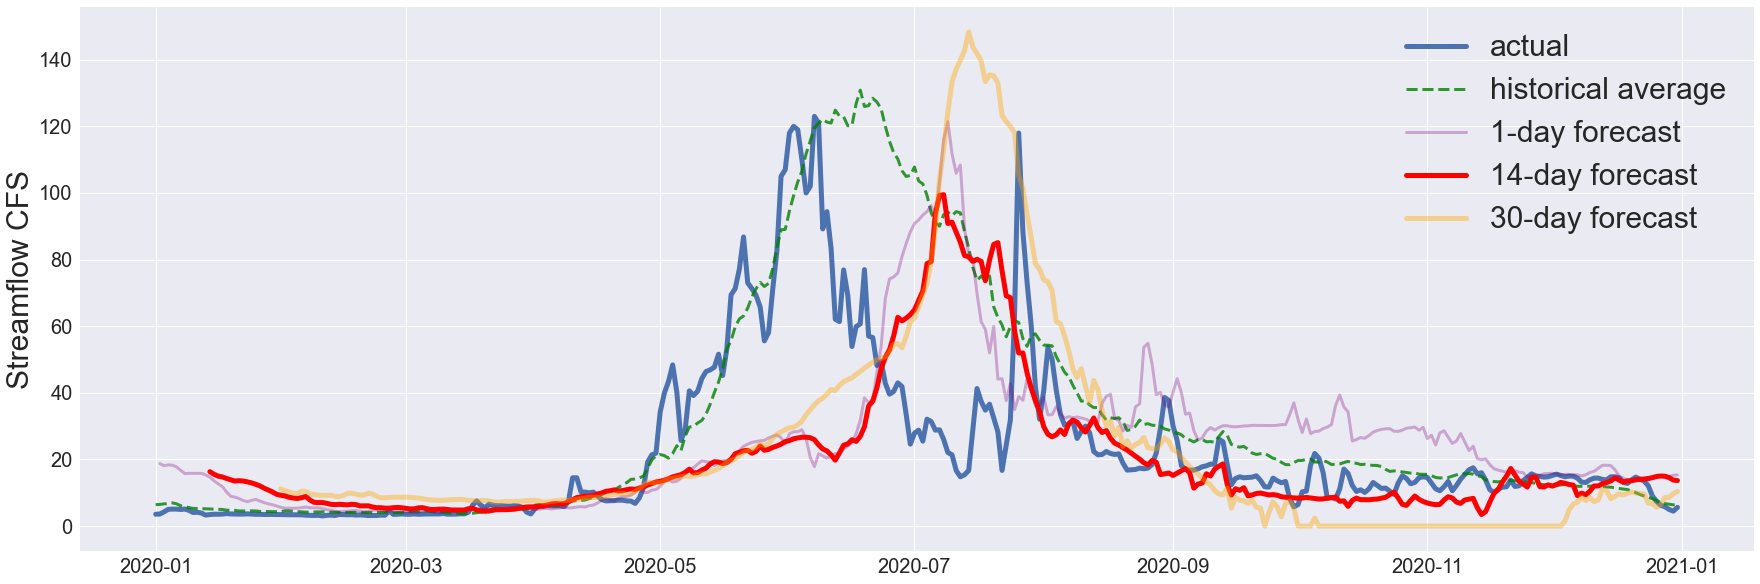

(None, None)

In [224]:
pass_year = '2020'
year_graph_lstm(lstm_v12, 'delme', pass_year, df), test_graph_lstm(lstm_v12, 'delme', pass_year, df)